In [1]:
DF_PATH = "../data/processed/1_preprocessed_df.pkl"

NA_STRING = 'Not Specified'
TRANSPARENT_STRING = 'rgba(0, 0, 0, 0)'

ROLE_COLS      = ['DevType']
TECH_COLS      = ['LanguageHaveWorkedWith',
                  'DatabaseHaveWorkedWith',
                  'WebframeHaveWorkedWith',
                  'MiscTechHaveWorkedWith',
                  'ToolsTechHaveWorkedWith']

EXPORT_FEATURES_DIR = "../data/processed/"

In [2]:
# Load packages
import pandas as pd 
import numpy as np
import logging
import pickle
import os
import yaml

import plotly 
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE

from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import silhouette_score

pd.options.display.max_rows = 1000

## Read data and preprocess data 

In [3]:
# Read Data 
df = pd.read_pickle(DF_PATH)

In [4]:
# One hot encode 
encoded_dfs = {}
for col in ROLE_COLS + TECH_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(df[col]),
                               columns=binarizer.classes_,
                               index=df[col].index)
    encoded_dfs[col] = encoded_df
    
# Merge 1-hot encoded 
ohe_df = pd.concat(encoded_dfs, axis=1)

_________________

## Dimensionality reduction 

In [5]:
# Prepare sub data frames 
skills_ohe = ohe_df.drop('DevType', axis=1).copy()
std_skills = StandardScaler().fit_transform(skills_ohe)

In [6]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=skills_ohe.columns)

In [7]:
tsne_projection.shape

(97, 2)

In [8]:
fig = px.scatter(x=tsne_projection[0], y=tsne_projection[1], text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()

_________________

## Cluster 

In [9]:
range_n_cluster = list(range(10,25))
silhoutte_score = []
best_cluster_model = None 

for n_clusters in range_n_cluster:
    cluster_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)
    
    silhouette_avg = silhouette_score(tsne_projection, cluster_labels)
    silhoutte_score += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score):
        best_cluster_model = cluster_model

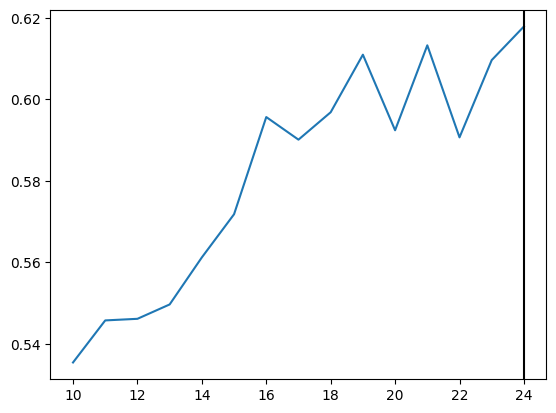

In [10]:
plt.plot(range_n_cluster, silhoutte_score)
plt.axvline(best_cluster_model.n_clusters, color='black')

In [11]:
cluster_labels = ["skills_group_" + str(label) 
                 for label in best_cluster_model.labels_]

In [12]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [13]:
# How to better write this
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)

In [14]:
for cluster, skills in skills_clusters.items():
    print(cluster)
    print(skills)

skills_group_0
['Go', 'Rust', 'DynamoDB', 'PostgreSQL', 'Ansible', 'Docker', 'Git', 'Kubernetes', 'Terraform']
skills_group_1
['PHP', 'MariaDB', 'MySQL', 'SQLite', 'Drupal', 'Laravel', 'Symfony', 'Vue.js']
skills_group_10
['SQL', 'VBA', 'Microsoft SQL Server']
skills_group_11
['Cassandra', 'Couchbase', 'Elasticsearch', 'Redis']
skills_group_12
['Svelte', 'Deno']
skills_group_13
['Groovy', 'Java', 'Kotlin', 'Oracle', 'Spring']
skills_group_14
['TypeScript', 'Angular', 'Angular.js', 'Cordova']
skills_group_15
['Ruby', 'Ruby on Rails']
skills_group_16
['Clojure', 'Haskell', 'LISP']
skills_group_17
['Scala', 'Apache Spark', 'Hadoop']
skills_group_18
['Bash/Shell', 'Perl']
skills_group_19
['Dart', 'Firebase', 'Flutter']
skills_group_2
['C#', 'F#', 'PowerShell', 'ASP.NET', 'ASP.NET Core ', '.NET Core / .NET 5', '.NET Framework', 'Xamarin']
skills_group_20
['Objective-C', 'Swift']
skills_group_21
['Unity 3D', 'Unreal Engine']
skills_group_22
['Keras', 'TensorFlow', 'Torch/PyTorch']
skills_gro

_________________

## Create new features  

In [15]:
new_features = []

for cluster, skills in skills_clusters.items():
    cluster_sum = skills_ohe.droplevel(0, axis=1)[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)

In [16]:
fe_clustered_skills

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,...,skills_group_21,skills_group_22,skills_group_23,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,1
1,3,1,0,0,0,0,2,0,0,0,...,0,0,0,1,2,0,0,1,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,3,0,0,2
3,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,0
4,4,0,1,2,0,0,0,0,0,2,...,0,0,0,1,2,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,2,1,1,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
83435,2,4,0,1,0,0,0,1,0,0,...,2,0,0,1,1,0,0,1,0,1
83436,6,0,0,2,0,2,0,0,0,1,...,0,1,0,1,3,0,2,0,0,0
83437,5,0,0,3,0,0,0,0,0,0,...,0,2,0,4,3,0,2,1,0,0


_________________

## Illustration Model

#### Create train / test matrices 

In [17]:
combined_features_df = pd.concat([fe_clustered_skills, 
                                  skills_ohe.droplevel(0,axis=1)], 
                                 axis=1)
roles_df = ohe_df['DevType'].copy()

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(combined_features_df, roles_df, test_size=0.3, random_state=0)

#### Compute samples weight to deal with classes imbalance 

In [19]:
# Assign class weight as an inverse of its frequency 
class_weights = (1 / roles_df.sum(axis=0))

# Multiply class weights with the 1 hot encoded values and get the mean of each sample
sample_weight = np.multiply(class_weights.values, Y_train.values).sum(axis=1)

#### Compute samples weight to deal with classes imbalance 

In [20]:
def f1_from_confusion_matrix(confusion_matrix):
    return (confusion_matrix[1,1] / 
            (confusion_matrix[1,1] + 
             (0.5 * (confusion_matrix[0,1] + confusion_matrix[1,0]))
            ))

In [21]:
feature_sets = {'original': skills_ohe.droplevel(0,axis=1).columns.tolist(), 
                'clusters': fe_clustered_skills.columns.tolist()}

In [22]:
results = {}

for feature_set_name, feature_set in feature_sets.items():
    # Create sub trainings
    sub_train = X_train[feature_set].copy()
    sub_test  = X_test[feature_set].copy()
    
    # Train classifier 
    clf = MultiOutputClassifier(LogisticRegression())
    clf.fit(sub_train, Y_train, sample_weight=sample_weight)

    # Calcaulte F1 for training data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_train, clf.predict(sub_train))
    f1_train_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Calcaulte F1 for testing data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_test, clf.predict(sub_test))
    f1_test_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Add to results
    set_result = pd.DataFrame({"train": f1_train_scores, "test":f1_test_scores}, 
                              index=roles_df.columns.to_list())
    results[feature_set_name] = set_result.sort_values('test')
    
    
    # Print
    print("Feature set: " + feature_set_name)
    print(".. Mean train F1:", np.mean(f1_train_scores))    
    print(".. Mean test F1:", np.mean(f1_test_scores))
    print()

Feature set: original
.. Mean train F1: 0.10894397378773973
.. Mean test F1: 0.1082290894138183

Feature set: clusters
.. Mean train F1: 0.14535507071144857
.. Mean test F1: 0.14656378115757607



_________________

## Export new features 

In [24]:
features_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters.pkl")
fe_clustered_skills.to_pickle(features_path)

In [25]:
description_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters_description.yaml")
with open(description_path, 'w') as outfile:
    yaml.dump(skills_clusters.to_dict(), outfile)